# Stellar Cluster Analysis Using GAIA and AstroPy
*Author: Eric G. Suchanek, Ph.D. 2/24/19 v0.2*

This notebook creates a list stars centered on the Pelican Nebula and does some analysis
of their proper motion in an effort to find clusters of co-migrating stars. It uses 
direct queries to the GAIA database to retrieve the stellar data. matplotlib is used 
to plot the results.

The notebook is meant to be pedagogical and shows various methods of manipulating 
the data structures used. Consequently, the code is not optimized and will be 
slow when working with a large search area, (resuting in large number of stars)!

### Useful Links
* AstroPy documentation: http://docs.astropy.org/en/stable/index.html
* Table manipulation: http://docs.astropy.org/en/stable/table/access_table.html
* Using SkyCoords: http://docs.astropy.org/en/stable/coordinates/skycoord.html#array-operations

In [1]:
#
# Setup the libraries. In general grab all of these
#
import astropy.units as u
import astropy.coordinates as coord

from astropy.coordinates import SkyCoord, Galactic, ICRS
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.visualization import astropy_mpl_style, quantity_support


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import numpy as np
import time
import progressbar

# enable quantity support
quantity_support()  

# use fancy Astronomy-style plotting
plt.style.use(astropy_mpl_style)


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


For this example we use the Pelican Nebula as center, and select all stars within 1 degree. One has to pass coordinates using the SkyCoord type, in the ICRS coordinate frame. The 'job' object returned by the Gaia searches contain the stars satisfying this initial center and radius. These queries can take minutes or more to run. The timings indicated were conducted
on a 2014 MacBook Pro, 2.5 GHz i7, 16 GB RAM, over a wireless connection.

In [9]:
# Get the SkyCoord for the Pelican Nebula object coordinates
# hard way, convert to decimal by hand

pel_ra = 20.8467
pel_dec = 44.35
c1 = SkyCoord(ra=pel_ra, dec=pel_dec, unit=(u.hourangle, u.degree), frame='icrs')

# easy way, pass using hms string notation.
PelicanNebulaCoords = SkyCoord("20h50m48s 44d20m59s", frame='icrs')
# print(PelicanNebulaCoords, "\n")

# Here are the primary parameters. size = the circle or rectangle size, error_cutoff is the % error in 
# proper motion that we want to use as maximum acceptable error

size = 1*u.deg # remember to cast into the correct units!
error_cutoff =.4

# this is a generic ADQL select string to do a direct query to the GAIA database.
# It takes parameters of ra, dec circle_radius, ra_error, dec_error 
# as input and results in a valid ADQL query that can be sent to GAIA via TAP+

# query string template for circular query
sel_str_circle = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1 \
AND abs(pmra_error/pmra)<{} \
AND abs(pmdec_error/pmdec)<{} \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0;"

# query string template for rectangular query

sel_str_box = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND abs(pmra_error/pmra)<{} \
AND abs(pmdec_error/pmdec)<{} \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0;"

#
# if you want to use the SkyCoord coordinates you pass this way:
# query_box = sel_str_box.format(PelicanNebulaCoords.ra.value, 
#                   PelicanNebulaCoords.dec.value, size.value,size.value, error_cutoff, error_cutoff)

# since we know the coordinates we can pass directly to create the query string
# These represent a conic query and a rectangular query, respectively. Only one is used at a time

query_circle = sel_str_circle.format(pel_ra, pel_dec, size.value, error_cutoff, error_cutoff)
query_box = sel_str_box.format(pel_ra, pel_dec, size.value,size.value, error_cutoff, error_cutoff)

# print the query to show the user how ugly it is
print("Here's the query we're sending: \n", query_box, "\n" )
# useful to debug by entering into:
# https://gea.esac.esa.int/archive/
# print(q)

# do a cone search
# save the result file to 'pelican_1deg' in the local directory
    
start = time.time()
#job = Gaia.launch_job_async(query, dump_to_file=False, output_file="pelican_neb")
 
job = Gaia.launch_job_async(query_box, dump_to_file=False, output_file="pelican_neb")
stars = job.get_results()

end = time.time()
print("Elapsed time was: ", end - start, " seconds")

# show a quick look at the results
# stars.pprint()
# print(stars.info())

print('Search query returned ', len(stars), 'stars, with pmra and pmdec errors < ', error_cutoff)


Here's the query we're sending: 
 SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',20.8467,44.35,1.0,1.0))=1 AND abs(pmra_error/pmra)<0.4 AND abs(pmdec_error/pmdec)<0.4 AND pmra IS NOT NULL AND abs(pmra)>0 AND pmdec IS NOT NULL AND abs(pmdec)>0; 

Query finished.
Elapsed time was:  12.44143009185791  seconds
Search query returned  4142 stars, with pmra and pmdec errors <  0.4


Now plot the RA and DEC proper motion. We use figures and subplots since this notebook has several plots

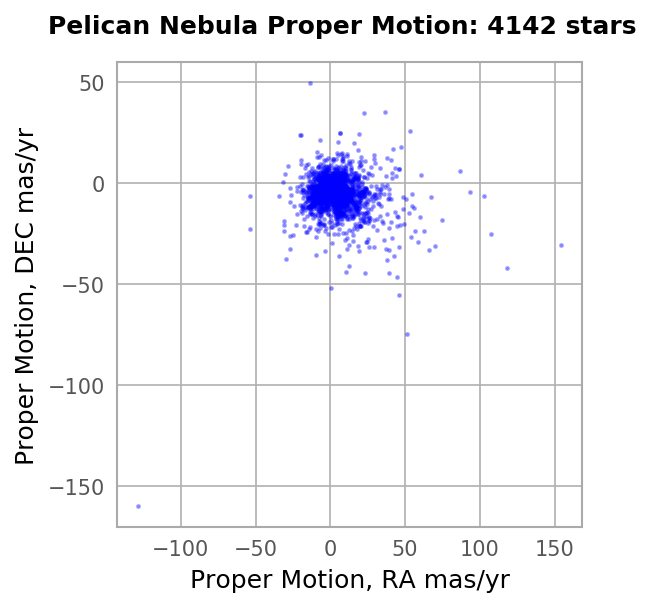

In [10]:
fig, ax = plt.subplots(figsize=(4,4),dpi=150)

ax.scatter(stars['pmra'], stars['pmdec'], color='b', alpha=0.3, s=2)

fig.subplots_adjust(top=0.90)
fig.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
             fontsize=12, fontweight='bold')
# ax.set_title('axes title')
ax.set_xlabel('Proper Motion, RA mas/yr')
ax.set_ylabel('Proper Motion, DEC mas/yr')

plt.show()


In [11]:
# find the maximum pm in ra and dec to scale the quiverkey
# take the absolute values to handle large negatives!

def determine_qkey_len(stars):
    #print(stars['pmra'])
    pmra_min = abs(np.min(stars['pmra']))
    pmra_max = abs(np.max(stars['pmra']))
    pmdec_min = abs(np.min(stars['pmdec']))
    pmdec_max = abs(np.max(stars['pmdec']))
    pm = [pmra_min, pmra_max, pmdec_min, pmdec_max]
    #print(pm)
    qk = int(max(pm)+.5)
    return(qk)



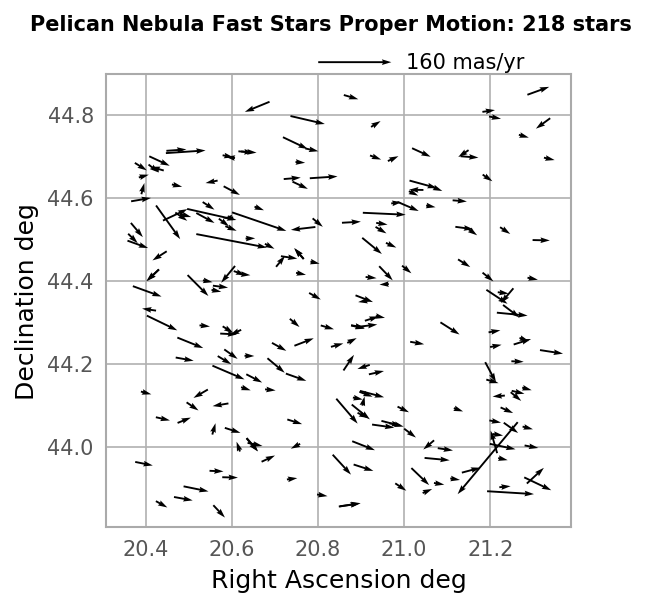

In [12]:
# 
# Now take a look at stars with high proper motion
# Pick a number for 'fast'
speedy = 20

# Very useful reference for manipulating the tables in AstroPy:
# http://docs.astropy.org/en/stable/table/access_table.html
#
# Create a 'mask' that represents the stars whose pmra or pmdec >= speedy
# then create the new list based on this mask

mask = (abs(stars['pmra']) >= speedy) | abs((stars['pmdec']) >= speedy)
faststars = stars[mask]

#
# Create a quiver plot of the stars, where the pmra and pmdec determine the 
# orientation of the arrows
#
fig2a, ax2a = plt.subplots(figsize=(4,4),dpi=150)
fig2a.suptitle('Pelican Nebula Fast Stars Proper Motion: '+ str(len(faststars))+ ' stars', 
              fontsize=10, fontweight='bold')

ax2a.set_xlabel('Right Ascension deg')
ax2a.set_ylabel('Declination deg')

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

X = faststars['ra']
Y = faststars['dec']
U = faststars['pmra']
V = faststars['pmdec']

qk_len = determine_qkey_len(faststars)
qk_str = str(qk_len) + ' mas/yr'

quiver_plot = ax2a.quiver(X, Y, U, V, angles='xy', units='xy')
ax2a.quiverkey(quiver_plot, X=0.6, Y=0.9, U=qk_len,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

Next we create a quiver plot of all the stars' proper motions.

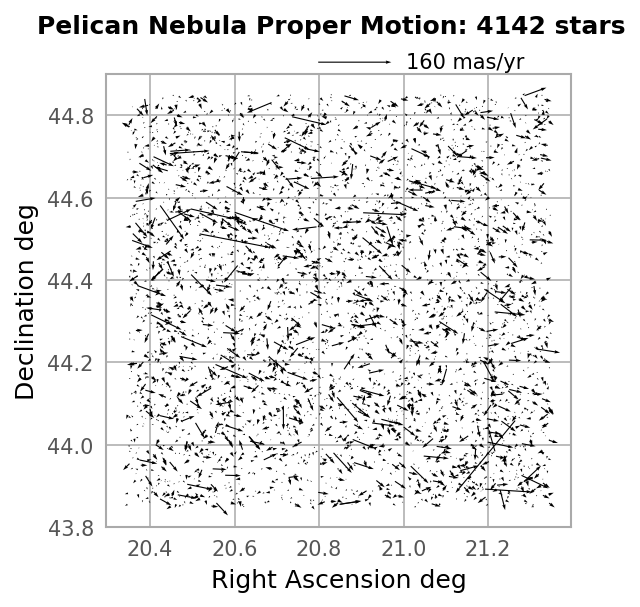

In [13]:
#
# Create a quiver plot of the stars, where the pmra and pmdec determine the 
# orientation of the arrows
#
fig2, ax2 = plt.subplots(figsize=(4,4),dpi=150)
fig2.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax2.set_xlabel('Right Ascension deg')
ax2.set_ylabel('Declination deg')

# determine the length of the quiverkey and make the string label
qk_len = determine_qkey_len(stars)
qk_str = str(qk_len) + ' mas/yr'

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

X = stars['ra']
Y = stars['dec']
U = stars['pmra']
V = stars['pmdec']

quiver_plot = ax2.quiver(X, Y, U, V, angles='xy', units='xy')
ax2.quiverkey(quiver_plot, X=0.6, Y=0.9, U=qk_len,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

Now we'll look at the distribution

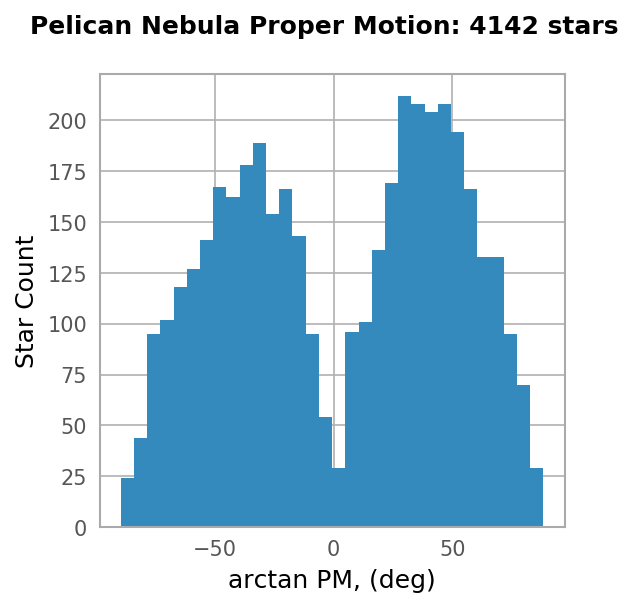

In [14]:
#
# Create a histogram plot of the stars, showing the distribution of the 
# PM angle (arctan(pmdec/pmdra))
#
fig3, ax3 = plt.subplots(figsize=(4,4),dpi=150)
fig3.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax3.set_xlabel('arctan PM, (deg)')
ax3.set_ylabel('Star Count')

to_deg = 180.0 / 3.1415
n_bins = 32
x = to_deg * np.arctan(stars['pmdec']/stars['pmra'])
ax3.hist(x, bins=n_bins)

plt.show()


## Subroutines and Utility Functions

In [15]:
#
# return a list containing non-zero radial velocities, converted to GSR coordinates
#
def get_radial_vals(star_list):
    """Returns a list containing non-zero Radial Velocities.

    The input star_list is a list object returned by job.results()

    Parameters
    ----------
    star_list : list returned by job.results()

    Returns
    -------
    v_gsr : list of coordinates containing ra, dec and non-zero 
        radial_velicities
    """
    i = count = 0
    x = []
    
    # make a fancy progressbar to monitor progress since this this iterates over
    # typically long star lists
    widgets=[
    ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    with progressbar.ProgressBar(max_value=len(star_list), widgets=widgets) as bar:
        for star in star_list:
            ra = star['ra'] * u.deg
            dec = star['dec'] * u.deg
            radial = star['radial_velocity'] * u.km/u.s
            star_icrs = coord.ICRS(ra=ra,dec=dec,radial_velocity=radial)
            if (star_icrs.radial_velocity != 0.0):
                x.append(rv_to_gsr(star_icrs).value)
                count = count + 1
            i = i + 1
            bar.update(i)
    return(x)  

In [16]:
#
# Function converts the barycentric radial velocity to GSR coordinate frame
# Example provided in the AstroPy documentation
#
def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a ICRS object

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinate, to be
        transformed.
    v_sun : `~astropy.units.Quantity` (optional)
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric.galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

 [Elapsed Time: 0:00:12] |##################################| (Time:  0:00:12) 


Elapsed time was: 12.854437112808228 seconds


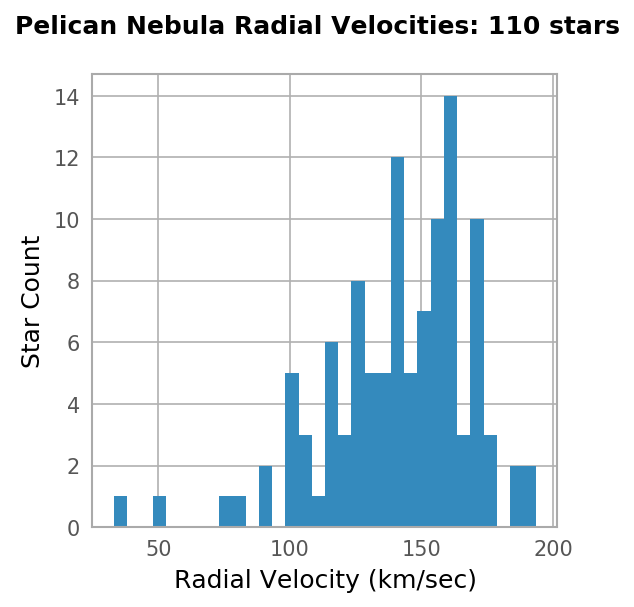

In [17]:
#
# Create a histogram plot of the stars' radial velocities
# 
#
fig4, ax4 = plt.subplots(figsize=(4,4),dpi=150)

ax4.set_xlabel('Radial Velocity (km/sec)')
ax4.set_ylabel('Star Count')

n_bins = 32

# convert radial velocity to GSR coordinate frame
# we have to convert each star into an ICRS object first in order
# to convert to GCRS via our function. Since I don't know how to check 
# for 'missing' items I do the converstion to an ICRS object. This will 
# set missing radial_velocities to zWe then check for non-zero radial velocities, convert them and plot

i = count = 0
vels = []

start = time.time()
vels = get_radial_vals(stars)
end = time.time()
print("Elapsed time was: " + str(end - start) + " seconds")

fig4.suptitle('Pelican Nebula Radial Velocities: '+ str(len(vels)) + ' stars', 
              fontsize=12, fontweight='bold')
ax4.hist(vels, bins=n_bins)

plt.show()

Now, we want to add information from other catalogues, in this example from 2MASS. To do this we make use of the pre-computed cross-matched tables provided in the Gaia archive.
We obtain the 2MASS photometric data by using the Gaia - 2MASS cross-matched best neighbour table (gaiadr1.tmass_best_neighbour) to identify the sources and the 2MASS original table (gaiadr1.tmass_original_valid) to retrieve the photometry:

Query finished.
Query finished.
DR1 results:   phot_g_mean_mag    j_m    h_m    ks_m 
       mag          mag    mag    mag  
------------------ ------ ------ ------
 12.39682802148695  11.25 10.875 10.887
  9.87784385104791  9.121  8.918  8.896
 11.83120108482604 10.754 10.421  10.38
  9.50265247771917  9.014  8.953   8.91
12.225137174924388 11.264 11.005 10.947
 8.733505081617754   8.43  8.411  8.359
  9.13207448901133  8.622  8.565  8.483
10.435216713178939  8.792  8.249  8.072
  8.64058850053513   7.07  6.505  6.419
10.941627626240539 10.355 10.201 10.159
               ...    ...    ...    ...
 10.82326046230936 10.351 10.286 10.224
11.824442480149992 11.014 10.714 10.654
10.278584583987227  8.929  8.445  8.387
11.002876749904589 10.208  9.989  9.976
 8.487981400222267  6.546  5.855  5.634
11.829148751028868 10.719 10.492   10.4
 8.316617877577425  6.454   5.83  5.667
 9.045422264707138   8.94  8.902  8.896
10.412156010725873  9.524  9.296  9.213
11.849563912208529 10.956 10.715 1

<b>The cells below are for testing/development</b>

In [ ]:
c1 = coord.ICRS(ra=89.014303*u.degree, dec=13.924912*u.degree,
                distance=(37.59*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=372.72*u.mas/u.yr,
                pm_dec=-483.69*u.mas/u.yr,
                radial_velocity=0.37*u.km/u.s)
print(c1)
gc1 = c1.transform_to(coord.Galactocentric)
print(gc1)

In [ ]:
#
# Convert all the stars into SkyCoord objects in the ICRS coordinate frame
# This enables us to use the SkyCoord functions directly.
# the stars_icrs list contains these
#

ra2 = stars['ra']
dec2 = stars['dec']
pmra2 = stars['pmra']
pmdec2 = stars['pmdec']
pm_ra_cosdec2 = np.cos(dec)
#radial = stars['radial_velocity']

stars_skycoord = SkyCoord(frame='icrs', ra = ra2, dec = dec2, 
                          pm_ra_cosdec = pm_ra_cosdec2*u.mas/u.yr, pm_dec = pmdec2)

print(stars_skycoord)

#gcl = stars_skycoord.transform_to(coord.Galactocentric)

In [ ]:
format_str_orig = "SELECT * \
FROM gaiadr1.gaia_source AS g, gaiadr1.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),CIRCLE('ICRS',{:.5f},{:.5},{:.5f}))=1 \
AND abs(g.pmra_error/g.pmra)<0.10 \
AND abs(g.pmdec_error/g.pmdec)<0.10 \
AND g.pmra IS NOT NULL AND abs(g.pmra)>0 \
AND g.pmdec IS NOT NULL AND abs(g.pmdec)>0 \
AND g.pmra BETWEEN 15 AND 25 \
AND g.pmdec BETWEEN -55 AND -40;"

q = format_str_orig.format(PelicanNebulaCoords.ra.value, PelicanNebulaCoords.dec.value, size.value)
print(q)

job6 = Gaia.launch_job_async(q, dump_to_file=False)

"""
job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source AS g, gaiadr1.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(g.pmra_error/g.pmra)<0.10 \
AND abs(g.pmdec_error/g.pmdec)<0.10 \
AND g.pmra IS NOT NULL AND abs(g.pmra)>0 \
AND g.pmdec IS NOT NULL AND abs(g.pmdec)>0 \
AND g.pmra BETWEEN 15 AND 25 \
AND g.pmdec BETWEEN -55 AND -40;", dump_to_file=False)
"""

